## 📦 Step 1: Importar Librerías y Configuración

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from scipy import signal
from scipy.interpolate import interp1d
import librosa
import librosa.display
import soundfile as sf
from IPython.display import Audio, display
from pathlib import Path
import os

# Configurar matplotlib
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['figure.dpi'] = 100

print("✅ Librerías importadas correctamente")
print(f"PyTorch versión: {torch.__version__}")

# Configurar dispositivo
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("🎮 GPU NVIDIA detectada (CUDA)")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("🍎 GPU Apple Silicon detectada (MPS)")
else:
    device = torch.device("cpu")
    print("💻 Usando CPU")

print(f"🖥️  Dispositivo de cómputo: {device}")

✅ Librerías importadas correctamente
PyTorch versión: 2.9.1
🍎 GPU Apple Silicon detectada (MPS)
🖥️  Dispositivo de cómputo: mps


## ⚙️ Step 2: Configuración de Parámetros

In [2]:
# ============================================
# CONFIGURACIÓN DEL PIPELINE
# ============================================

# Rutas
AUDIO_DIR = Path("../VCTK-Corpus/VCTK/Dataset_2Seg")
MODEL_PATH = Path("../Models/CnnModel2/models_multifactor/best_model_upsample5x.pth")
OUTPUT_DIR = Path("./output")
OUTPUT_DIR.mkdir(exist_ok=True)

# Parámetros de segmentación
CHUNK_SIZE = 5000          # Muestras por chunk (alta resolución)
OVERLAP = 500              # Solapamiento entre chunks
HOP_SIZE = CHUNK_SIZE - OVERLAP  # Paso entre chunks (4500)

# Parámetros de downsampling
INPUT_SIZE = 1000          # Tamaño de entrada al modelo (baja resolución)
OUTPUT_SIZE = 5000         # Tamaño de salida del modelo (alta resolución)
DOWNSAMPLE_FACTOR = CHUNK_SIZE // INPUT_SIZE  # Factor 5x

# Parámetros del filtro anti-aliasing (Butterworth)
FILTER_ORDER = 8           # Orden del filtro
NYQUIST_RATIO = 0.9        # 90% del Nyquist de la frecuencia destino

# Verificar rutas
print("="*60)
print("CONFIGURACIÓN DEL PIPELINE")
print("="*60)
print(f"📂 Directorio de audio: {AUDIO_DIR}")
print(f"📂 Audio existe: {AUDIO_DIR.exists()}")
print(f"🧠 Ruta del modelo: {MODEL_PATH}")
print(f"🧠 Modelo existe: {MODEL_PATH.exists()}")
print(f"💾 Directorio de salida: {OUTPUT_DIR}")
print("\n--- Parámetros de Segmentación ---")
print(f"📊 Chunk size: {CHUNK_SIZE} muestras")
print(f"📊 Overlap: {OVERLAP} muestras")
print(f"📊 Hop size: {HOP_SIZE} muestras")
print("\n--- Parámetros de Downsampling ---")
print(f"⬇️  Factor de downsampling: {DOWNSAMPLE_FACTOR}x")
print(f"⬇️  Input size (low-res): {INPUT_SIZE} muestras")
print(f"⬆️  Output size (high-res): {OUTPUT_SIZE} muestras")
print(f"🔊 Filtro Butterworth: orden {FILTER_ORDER}, cutoff {NYQUIST_RATIO*100}% Nyquist")
print("="*60)

# Listar archivos de audio disponibles
audio_files = sorted([f for f in AUDIO_DIR.glob("*.wav")])
print(f"\n📁 Total de archivos WAV disponibles: {len(audio_files)}")
if len(audio_files) > 0:
    print(f"   Primeros 5: {[f.name for f in audio_files[:5]]}")

CONFIGURACIÓN DEL PIPELINE
📂 Directorio de audio: ../VCTK-Corpus/VCTK/Dataset_2Seg
📂 Audio existe: True
🧠 Ruta del modelo: ../Models/CnnModel2/models_multifactor/best_model_upsample5x.pth
🧠 Modelo existe: True
💾 Directorio de salida: output

--- Parámetros de Segmentación ---
📊 Chunk size: 5000 muestras
📊 Overlap: 500 muestras
📊 Hop size: 4500 muestras

--- Parámetros de Downsampling ---
⬇️  Factor de downsampling: 5x
⬇️  Input size (low-res): 1000 muestras
⬆️  Output size (high-res): 5000 muestras
🔊 Filtro Butterworth: orden 8, cutoff 90.0% Nyquist

📁 Total de archivos WAV disponibles: 2411
   Primeros 5: ['p225_033.wav', 'p225_039.wav', 'p225_051.wav', 'p225_123.wav', 'p225_193.wav']


## 🏗️ Step 3: Definir Arquitectura del Modelo CNN

Replicamos exactamente la arquitectura `TimeSeriesSRNet` usada en el entrenamiento.

In [5]:
class TimeSeriesSRNet(nn.Module):
    """
    Convolutional Neural Network for Super-Resolution of Time Series.
    
    Encoder-Decoder Architecture:
    - Encoder: Extracts multi-scale features
    - Upsampler: Increases resolution and refines the signal
    
    Args:
        input_size (int): Input signal length
        output_size (int): Desired output signal length
        hidden_channels (list): Channels in each encoder layer
    """
    def __init__(self, input_size=1000, output_size=5000, hidden_channels=[64, 128, 256]):
        super(TimeSeriesSRNet, self).__init__()
        
        self.input_size = input_size
        self.output_size = output_size
        
        # ==================== ENCODER ====================
        self.encoder = nn.Sequential(
            # Layer 1: 1 → 64 channels
            nn.Conv1d(1, hidden_channels[0], kernel_size=9, stride=1, padding=4),
            nn.BatchNorm1d(hidden_channels[0]),
            nn.ReLU(inplace=True),
            
            # Layer 2: 64 → 128 channels
            nn.Conv1d(hidden_channels[0], hidden_channels[1], kernel_size=5, stride=1, padding=2),
            nn.BatchNorm1d(hidden_channels[1]),
            nn.ReLU(inplace=True),
            
            # Layer 3: 128 → 256 channels
            nn.Conv1d(hidden_channels[1], hidden_channels[2], kernel_size=5, stride=1, padding=2),
            nn.BatchNorm1d(hidden_channels[2]),
            nn.ReLU(inplace=True),
        )
        
        # ==================== UPSAMPLER ====================
        self.upsample = nn.Sequential(
            # Linear upsampling to exact output size
            nn.Upsample(size=output_size, mode='linear', align_corners=True),
            
            # Refinement: 256 → 128 channels
            nn.Conv1d(hidden_channels[2], hidden_channels[1], kernel_size=5, stride=1, padding=2),
            nn.BatchNorm1d(hidden_channels[1]),
            nn.ReLU(inplace=True),
            
            # Refinement: 128 → 64 channels
            nn.Conv1d(hidden_channels[1], hidden_channels[0], kernel_size=5, stride=1, padding=2),
            nn.BatchNorm1d(hidden_channels[0]),
            nn.ReLU(inplace=True),
            
            # Output: 64 → 1 channel (final signal)
            nn.Conv1d(hidden_channels[0], 1, kernel_size=9, stride=1, padding=4)
        )
    
    def forward(self, x):
        features = self.encoder(x)
        output = self.upsample(features)
        return output

print("✅ Arquitectura TimeSeriesSRNet definida")

✅ Arquitectura TimeSeriesSRNet definida


## 📥 Step 4: Cargar Modelo Pre-entrenado

In [6]:
# Crear instancia del modelo
model = TimeSeriesSRNet(input_size=INPUT_SIZE, output_size=OUTPUT_SIZE)

# Cargar pesos pre-entrenados
if MODEL_PATH.exists():
    checkpoint = torch.load(MODEL_PATH, map_location=device, weights_only=False)
    
    # El checkpoint contiene un diccionario con múltiples campos
    # Extraer solo los pesos del modelo
    if 'model_state_dict' in checkpoint:
        model.load_state_dict(checkpoint['model_state_dict'])
        print(f"✅ Modelo cargado desde checkpoint (época {checkpoint.get('epoch', 'N/A')})")
        print(f"   Val Loss guardado: {checkpoint.get('val_loss', 'N/A'):.6f}" if checkpoint.get('val_loss') else "")
    else:
        # Si es un state_dict directo
        model.load_state_dict(checkpoint)
        print(f"✅ Modelo cargado (state_dict directo)")
    
    model.to(device)
    model.eval()  # Modo evaluación (desactiva dropout, BatchNorm en modo inferencia)
    print(f"   Dispositivo: {device}")
    
    # Contar parámetros
    total_params = sum(p.numel() for p in model.parameters())
    print(f"   Parámetros totales: {total_params:,}")
else:
    print(f"❌ ERROR: No se encontró el modelo en {MODEL_PATH}")
    print("   Por favor verifica la ruta.")

✅ Modelo cargado desde checkpoint (época 30)
   Val Loss guardado: 0.084546
   Dispositivo: mps
   Parámetros totales: 412,673


## 🔧 Step 5: Funciones del Pipeline

Definimos todas las funciones necesarias para el procesamiento.

In [7]:
def load_audio(filepath):
    """
    Carga un archivo de audio WAV.
    
    Returns:
        y: señal de audio (numpy array)
        sr: sample rate
    """
    y, sr = librosa.load(filepath, sr=None)  # Preservar sample rate original
    return y, sr


def segment_audio(y, chunk_size=5000, hop_size=4500):
    """
    Divide la señal de audio en chunks con solapamiento.
    
    Args:
        y: señal de audio
        chunk_size: tamaño de cada chunk
        hop_size: paso entre chunks (chunk_size - overlap)
    
    Returns:
        chunks: lista de arrays numpy, cada uno de tamaño chunk_size
        positions: lista de posiciones de inicio de cada chunk
    """
    chunks = []
    positions = []
    
    n_samples = len(y)
    start = 0
    
    while start + chunk_size <= n_samples:
        chunk = y[start:start + chunk_size]
        chunks.append(chunk)
        positions.append(start)
        start += hop_size
    
    # Manejar el último chunk si hay muestras residuales
    if start < n_samples:
        # Rellenar con reflexión (mirror padding) para evitar artefactos
        remaining = n_samples - start
        if remaining > chunk_size // 2:  # Solo si vale la pena
            last_chunk = np.zeros(chunk_size)
            last_chunk[:remaining] = y[start:]
            # Reflexión del final
            last_chunk[remaining:] = y[-(chunk_size - remaining):][::-1][:chunk_size - remaining]
            chunks.append(last_chunk)
            positions.append(start)
    
    return chunks, positions


def apply_antialiasing_filter(chunk, sr, target_samples, filter_order=8, nyquist_ratio=0.9):
    """
    Aplica filtro Butterworth anti-aliasing antes del downsampling.
    
    Args:
        chunk: señal de entrada
        sr: sample rate original
        target_samples: número de muestras objetivo después del downsampling
        filter_order: orden del filtro Butterworth
        nyquist_ratio: fracción del Nyquist objetivo para el cutoff
    
    Returns:
        filtered_chunk: señal filtrada
    """
    # Calcular frecuencia de Nyquist del target
    downsample_factor = len(chunk) / target_samples
    target_sr = sr / downsample_factor
    target_nyquist = target_sr / 2
    
    # Frecuencia de corte del filtro
    cutoff = target_nyquist * nyquist_ratio
    
    # Normalizar cutoff respecto al Nyquist original
    original_nyquist = sr / 2
    normalized_cutoff = cutoff / original_nyquist
    
    # Asegurar que el cutoff normalizado esté en rango válido
    normalized_cutoff = min(normalized_cutoff, 0.99)
    
    # Diseñar filtro Butterworth
    b, a = signal.butter(filter_order, normalized_cutoff, btype='low')
    
    # Aplicar filtro zero-phase (filtfilt)
    filtered_chunk = signal.filtfilt(b, a, chunk)
    
    return filtered_chunk


def downsample_linear(chunk, target_samples):
    """
    Realiza downsampling usando interpolación lineal.
    
    Args:
        chunk: señal de entrada (alta resolución)
        target_samples: número de muestras objetivo (baja resolución)
    
    Returns:
        downsampled: señal de baja resolución
    """
    # Dominio original
    x_original = np.linspace(0, 1, len(chunk))
    
    # Dominio objetivo
    x_target = np.linspace(0, 1, target_samples)
    
    # Interpolador lineal
    interpolator = interp1d(x_original, chunk, kind='linear')
    
    # Evaluar en puntos objetivo
    downsampled = interpolator(x_target)
    
    return downsampled


def reconstruct_chunk(model, chunk_low_res, device):
    """
    Usa el modelo CNN para reconstruir un chunk de alta resolución.
    
    Args:
        model: modelo TimeSeriesSRNet
        chunk_low_res: chunk de baja resolución (numpy array)
        device: dispositivo de cómputo
    
    Returns:
        chunk_high_res: chunk reconstruido (numpy array)
    """
    # Convertir a tensor
    x = torch.tensor(chunk_low_res, dtype=torch.float32)
    x = x.unsqueeze(0).unsqueeze(0)  # [1, 1, input_size]
    x = x.to(device)
    
    # Forward pass
    with torch.no_grad():
        y_pred = model(x)
    
    # Convertir a numpy
    chunk_high_res = y_pred.squeeze().cpu().numpy()
    
    return chunk_high_res


def create_hann_window(overlap_size):
    """
    Crea una ventana Hann para suavizar el solapamiento.
    
    Returns:
        fade_out: ventana para el chunk actual (decrece)
        fade_in: ventana para el chunk siguiente (crece)
    """
    hann = np.hanning(2 * overlap_size)
    fade_out = hann[:overlap_size]  # Primera mitad (decrece de 1 a 0)
    fade_in = hann[overlap_size:]   # Segunda mitad (crece de 0 a 1)
    return fade_out, fade_in


def recombine_chunks(chunks_reconstructed, positions, overlap_size, total_length):
    """
    Recombina los chunks reconstruidos usando ventanas Hann en el solapamiento.
    
    Args:
        chunks_reconstructed: lista de chunks reconstruidos
        positions: posiciones de inicio originales
        overlap_size: tamaño del solapamiento
        total_length: longitud total de la señal original
    
    Returns:
        output: señal reconstruida completa
    """
    chunk_size = len(chunks_reconstructed[0])
    hop_size = chunk_size - overlap_size
    
    # Crear ventanas Hann
    fade_out, fade_in = create_hann_window(overlap_size)
    
    # Calcular longitud de salida
    output_length = positions[-1] + chunk_size if len(chunks_reconstructed) > 0 else 0
    output_length = min(output_length, total_length + overlap_size)  # No exceder original + margen
    
    # Inicializar buffer de salida
    output = np.zeros(output_length)
    
    for i, (chunk, pos) in enumerate(zip(chunks_reconstructed, positions)):
        if i == 0:
            # Primer chunk: tomar completo (sin fade-in)
            end_idx = min(pos + chunk_size, output_length)
            chunk_len = end_idx - pos
            output[pos:end_idx] = chunk[:chunk_len]
        else:
            # Chunks siguientes: aplicar crossfade en el solapamiento
            overlap_start = pos
            overlap_end = min(pos + overlap_size, output_length)
            non_overlap_start = overlap_end
            non_overlap_end = min(pos + chunk_size, output_length)
            
            actual_overlap = overlap_end - overlap_start
            
            if actual_overlap > 0:
                # Región de solapamiento: crossfade
                # El chunk anterior ya tiene valores aquí, aplicar fade-out
                # El chunk actual aporta con fade-in
                output[overlap_start:overlap_end] = (
                    output[overlap_start:overlap_end] * fade_out[:actual_overlap] +
                    chunk[:actual_overlap] * fade_in[:actual_overlap]
                )
            
            # Región sin solapamiento: tomar directamente del chunk actual
            if non_overlap_end > non_overlap_start:
                chunk_non_overlap = chunk[overlap_size:overlap_size + (non_overlap_end - non_overlap_start)]
                output[non_overlap_start:non_overlap_end] = chunk_non_overlap
    
    # Recortar a la longitud original
    output = output[:total_length]
    
    return output


print("✅ Funciones del pipeline definidas:")
print("   - load_audio()")
print("   - segment_audio()")
print("   - apply_antialiasing_filter()")
print("   - downsample_linear()")
print("   - reconstruct_chunk()")
print("   - create_hann_window()")
print("   - recombine_chunks()")

✅ Funciones del pipeline definidas:
   - load_audio()
   - segment_audio()
   - apply_antialiasing_filter()
   - downsample_linear()
   - reconstruct_chunk()
   - create_hann_window()
   - recombine_chunks()


## 🚀 Step 6: Pipeline Completo de Reconstrucción

In [8]:
def full_reconstruction_pipeline(audio_path, model, device, 
                                  chunk_size=5000, overlap=500,
                                  input_size=1000, filter_order=8,
                                  nyquist_ratio=0.9, verbose=True):
    """
    Pipeline completo de reconstrucción de audio usando super-resolución.
    
    Args:
        audio_path: ruta al archivo de audio
        model: modelo CNN pre-entrenado
        device: dispositivo de cómputo
        chunk_size: tamaño de chunks (alta resolución)
        overlap: solapamiento entre chunks
        input_size: tamaño de entrada al modelo (baja resolución)
        filter_order: orden del filtro Butterworth
        nyquist_ratio: ratio de cutoff respecto a Nyquist
        verbose: imprimir información de progreso
    
    Returns:
        original: señal original
        degraded: señal degradada (sin reconstruir, solo para comparación)
        reconstructed: señal reconstruida
        sr: sample rate
    """
    hop_size = chunk_size - overlap
    
    # 1. Cargar audio
    if verbose:
        print(f"📥 Cargando audio: {audio_path.name}")
    original, sr = load_audio(audio_path)
    original_length = len(original)
    
    if verbose:
        duration = original_length / sr
        print(f"   Duración: {duration:.3f}s, Muestras: {original_length}, SR: {sr} Hz")
    
    # 2. Segmentar en chunks
    if verbose:
        print(f"✂️  Segmentando en chunks de {chunk_size} con overlap {overlap}...")
    chunks, positions = segment_audio(original, chunk_size, hop_size)
    
    if verbose:
        print(f"   Chunks generados: {len(chunks)}")
    
    # 3. Procesar cada chunk
    chunks_low_res = []  # Para visualización de degradación
    chunks_reconstructed = []
    
    for i, chunk in enumerate(chunks):
        # 3a. Aplicar filtro anti-aliasing
        chunk_filtered = apply_antialiasing_filter(
            chunk, sr, input_size, filter_order, nyquist_ratio
        )
        
        # 3b. Downsample
        chunk_low = downsample_linear(chunk_filtered, input_size)
        chunks_low_res.append(chunk_low)
        
        # 3c. Reconstruir con modelo CNN
        chunk_reconstructed = reconstruct_chunk(model, chunk_low, device)
        chunks_reconstructed.append(chunk_reconstructed)
        
        if verbose and (i + 1) % 5 == 0:
            print(f"   Procesados {i + 1}/{len(chunks)} chunks...")
    
    if verbose:
        print(f"   ✅ Todos los chunks procesados")
    
    # 4. Recombinar chunks
    if verbose:
        print(f"🔗 Recombinando chunks con ventanas Hann...")
    reconstructed = recombine_chunks(chunks_reconstructed, positions, overlap, original_length)
    
    # 5. Crear versión degradada para comparación (upsampling simple de low-res)
    # Esto es solo para visualización - recombinamos los chunks de baja res
    chunks_degraded_upsampled = []
    for chunk_low in chunks_low_res:
        # Upsample simple con interpolación lineal (sin reconstrucción CNN)
        x_low = np.linspace(0, 1, len(chunk_low))
        x_high = np.linspace(0, 1, chunk_size)
        interpolator = interp1d(x_low, chunk_low, kind='linear')
        chunks_degraded_upsampled.append(interpolator(x_high))
    
    degraded = recombine_chunks(chunks_degraded_upsampled, positions, overlap, original_length)
    
    if verbose:
        print(f"✅ Reconstrucción completada")
        print(f"   Longitud original: {len(original)}")
        print(f"   Longitud reconstruida: {len(reconstructed)}")
    
    return original, degraded, reconstructed, sr


print("✅ Pipeline completo definido: full_reconstruction_pipeline()")

✅ Pipeline completo definido: full_reconstruction_pipeline()


## 🎵 Step 7: Seleccionar y Procesar un Audio de Prueba

In [9]:
# Seleccionar un archivo de audio para probar
# Puedes cambiar el índice para probar diferentes archivos
TEST_INDEX = 0  # Cambiar este valor para probar otros archivos

if len(audio_files) > TEST_INDEX:
    test_audio_path = audio_files[TEST_INDEX]
    print(f"🎵 Archivo seleccionado: {test_audio_path.name}")
    print(f"   Ruta completa: {test_audio_path}")
else:
    print("❌ No hay archivos de audio disponibles")

🎵 Archivo seleccionado: p225_033.wav
   Ruta completa: ../VCTK-Corpus/VCTK/Dataset_2Seg/p225_033.wav


In [10]:
# Ejecutar el pipeline de reconstrucción
print("="*60)
print("EJECUTANDO PIPELINE DE RECONSTRUCCIÓN")
print("="*60)

original, degraded, reconstructed, sr = full_reconstruction_pipeline(
    audio_path=test_audio_path,
    model=model,
    device=device,
    chunk_size=CHUNK_SIZE,
    overlap=OVERLAP,
    input_size=INPUT_SIZE,
    filter_order=FILTER_ORDER,
    nyquist_ratio=NYQUIST_RATIO,
    verbose=True
)

print("="*60)

EJECUTANDO PIPELINE DE RECONSTRUCCIÓN
📥 Cargando audio: p225_033.wav
   Duración: 2.000s, Muestras: 96000, SR: 48000 Hz
✂️  Segmentando en chunks de 5000 con overlap 500...
   Chunks generados: 21
   Procesados 5/21 chunks...
   Procesados 10/21 chunks...
   Procesados 15/21 chunks...
   Procesados 20/21 chunks...
   ✅ Todos los chunks procesados
🔗 Recombinando chunks con ventanas Hann...
✅ Reconstrucción completada
   Longitud original: 96000
   Longitud reconstruida: 95000


## 📊 Step 8: Visualización de Resultados

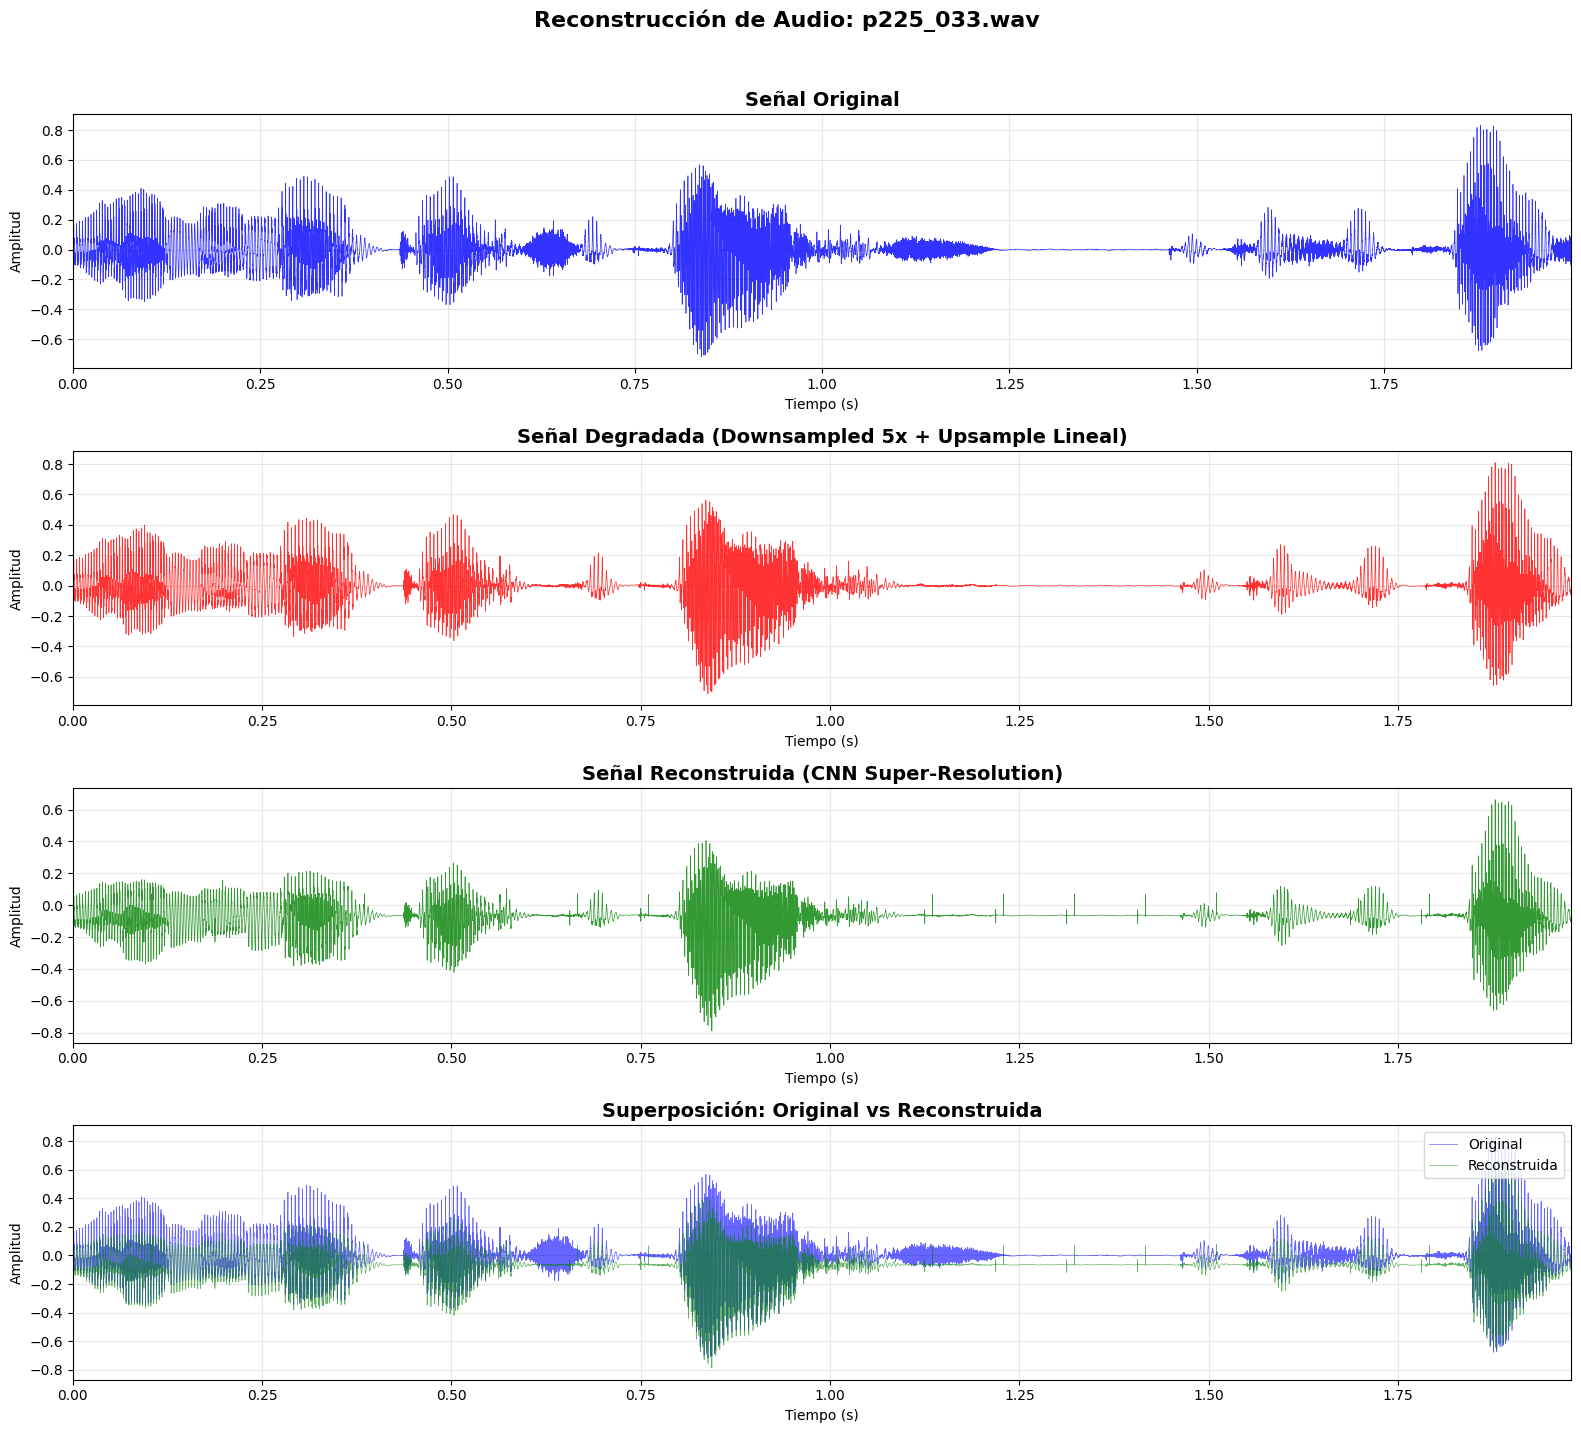

In [11]:
def plot_comparison(original, degraded, reconstructed, sr, title="Comparación de Señales"):
    """
    Visualiza la comparación entre señal original, degradada y reconstruida.
    """
    fig, axes = plt.subplots(4, 1, figsize=(16, 14))
    
    time = np.arange(len(original)) / sr
    
    # 1. Señal Original
    axes[0].plot(time, original, color='blue', linewidth=0.5, alpha=0.8)
    axes[0].set_title('Señal Original', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Tiempo (s)')
    axes[0].set_ylabel('Amplitud')
    axes[0].grid(True, alpha=0.3)
    axes[0].set_xlim([0, time[-1]])
    
    # 2. Señal Degradada (upsampled simple)
    time_deg = np.arange(len(degraded)) / sr
    axes[1].plot(time_deg, degraded, color='red', linewidth=0.5, alpha=0.8)
    axes[1].set_title('Señal Degradada (Downsampled 5x + Upsample Lineal)', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Tiempo (s)')
    axes[1].set_ylabel('Amplitud')
    axes[1].grid(True, alpha=0.3)
    axes[1].set_xlim([0, time_deg[-1]])
    
    # 3. Señal Reconstruida
    time_rec = np.arange(len(reconstructed)) / sr
    axes[2].plot(time_rec, reconstructed, color='green', linewidth=0.5, alpha=0.8)
    axes[2].set_title('Señal Reconstruida (CNN Super-Resolution)', fontsize=14, fontweight='bold')
    axes[2].set_xlabel('Tiempo (s)')
    axes[2].set_ylabel('Amplitud')
    axes[2].grid(True, alpha=0.3)
    axes[2].set_xlim([0, time_rec[-1]])
    
    # 4. Superposición para comparar
    min_len = min(len(original), len(reconstructed))
    time_overlay = np.arange(min_len) / sr
    axes[3].plot(time_overlay, original[:min_len], color='blue', linewidth=0.5, alpha=0.6, label='Original')
    axes[3].plot(time_overlay, reconstructed[:min_len], color='green', linewidth=0.5, alpha=0.6, label='Reconstruida')
    axes[3].set_title('Superposición: Original vs Reconstruida', fontsize=14, fontweight='bold')
    axes[3].set_xlabel('Tiempo (s)')
    axes[3].set_ylabel('Amplitud')
    axes[3].grid(True, alpha=0.3)
    axes[3].legend(loc='upper right')
    axes[3].set_xlim([0, time_overlay[-1]])
    
    plt.suptitle(title, fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()


# Visualizar
plot_comparison(original, degraded, reconstructed, sr, 
                title=f"Reconstrucción de Audio: {test_audio_path.name}")

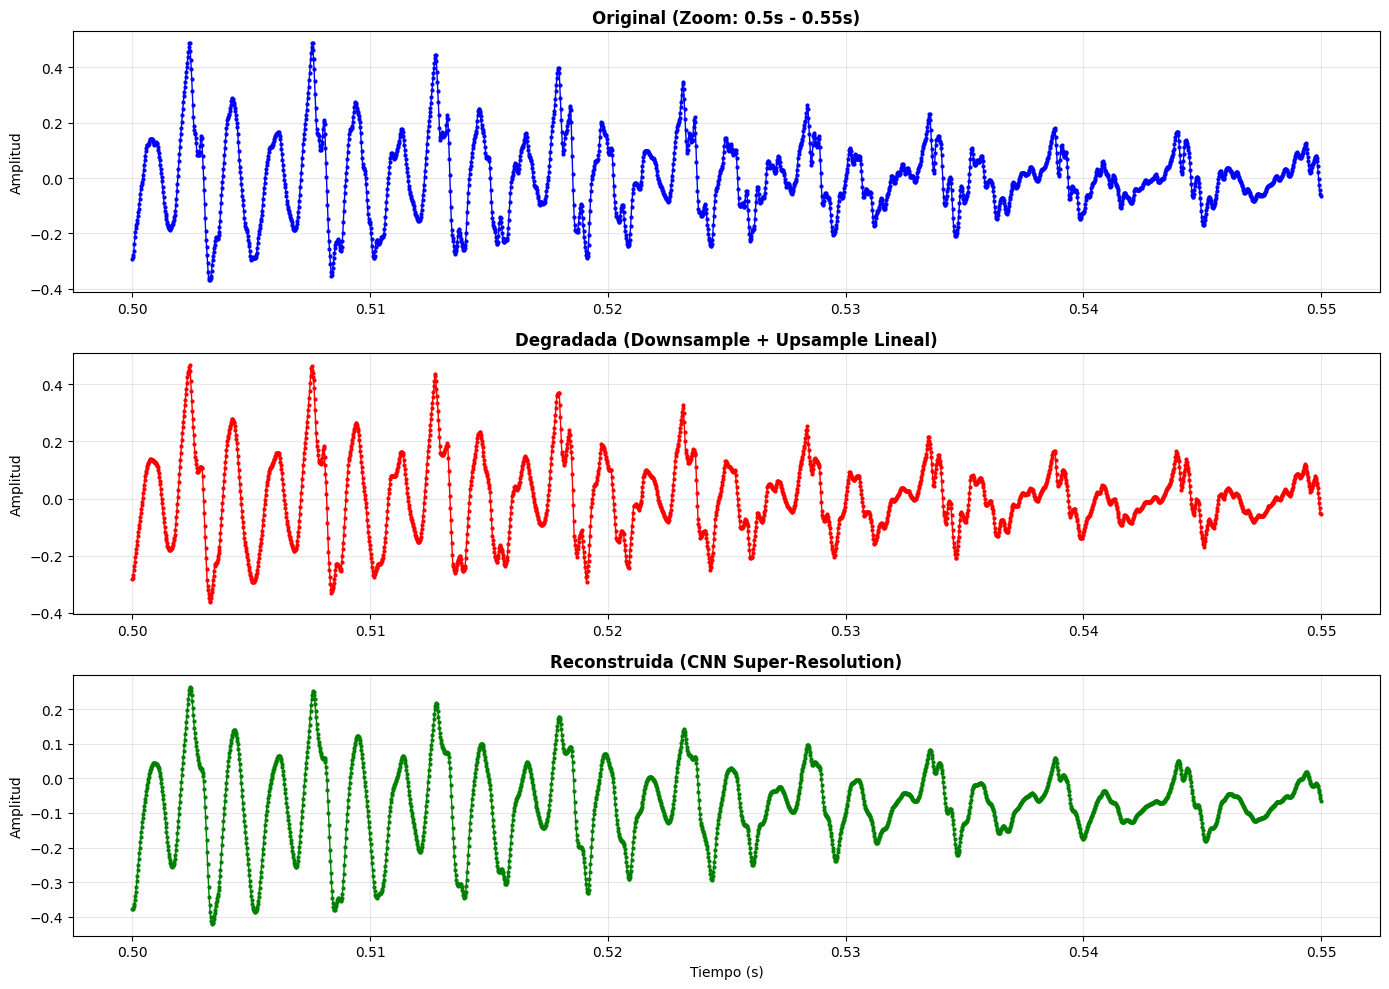

In [12]:
# Zoom en una sección para ver detalles
def plot_zoom(original, degraded, reconstructed, sr, start_time=0.5, duration=0.1):
    """
    Visualiza un zoom en una sección específica de las señales.
    """
    start_sample = int(start_time * sr)
    end_sample = int((start_time + duration) * sr)
    
    # Asegurar que no excedemos los límites
    end_sample = min(end_sample, len(original), len(degraded), len(reconstructed))
    
    fig, axes = plt.subplots(3, 1, figsize=(14, 10))
    
    time = np.arange(start_sample, end_sample) / sr
    
    # Original
    axes[0].plot(time, original[start_sample:end_sample], 'b-', linewidth=1, marker='o', markersize=2)
    axes[0].set_title(f'Original (Zoom: {start_time}s - {start_time+duration}s)', fontweight='bold')
    axes[0].set_ylabel('Amplitud')
    axes[0].grid(True, alpha=0.3)
    
    # Degradada
    axes[1].plot(time, degraded[start_sample:end_sample], 'r-', linewidth=1, marker='o', markersize=2)
    axes[1].set_title('Degradada (Downsample + Upsample Lineal)', fontweight='bold')
    axes[1].set_ylabel('Amplitud')
    axes[1].grid(True, alpha=0.3)
    
    # Reconstruida
    axes[2].plot(time, reconstructed[start_sample:end_sample], 'g-', linewidth=1, marker='o', markersize=2)
    axes[2].set_title('Reconstruida (CNN Super-Resolution)', fontweight='bold')
    axes[2].set_xlabel('Tiempo (s)')
    axes[2].set_ylabel('Amplitud')
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


# Mostrar zoom
plot_zoom(original, degraded, reconstructed, sr, start_time=0.5, duration=0.05)

## 📈 Step 9: Análisis Espectral (Espectrogramas)

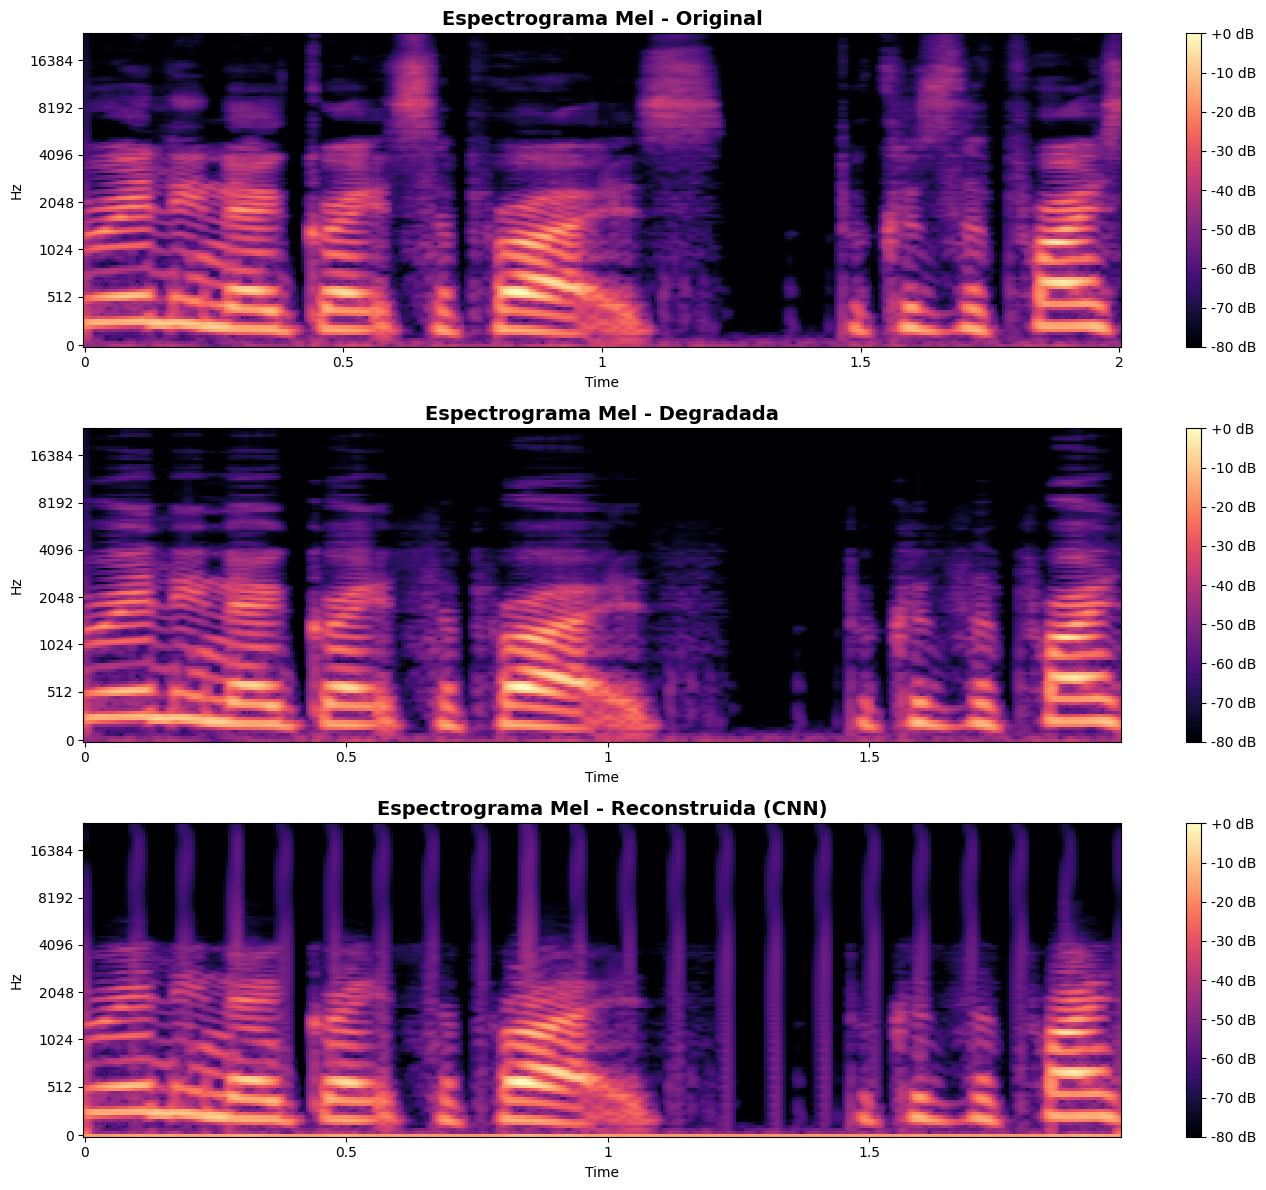

In [13]:
def plot_spectrograms(original, degraded, reconstructed, sr):
    """
    Genera espectrogramas Mel para comparar las señales.
    """
    fig, axes = plt.subplots(3, 1, figsize=(14, 12))
    
    # Parámetros del espectrograma
    n_mels = 128
    hop_length = 256
    
    # Espectrograma Original
    S_orig = librosa.feature.melspectrogram(y=original, sr=sr, n_mels=n_mels, hop_length=hop_length)
    S_orig_db = librosa.power_to_db(S_orig, ref=np.max)
    img1 = librosa.display.specshow(S_orig_db, sr=sr, hop_length=hop_length, 
                                     x_axis='time', y_axis='mel', ax=axes[0])
    axes[0].set_title('Espectrograma Mel - Original', fontsize=14, fontweight='bold')
    fig.colorbar(img1, ax=axes[0], format='%+2.0f dB')
    
    # Espectrograma Degradada
    S_deg = librosa.feature.melspectrogram(y=degraded, sr=sr, n_mels=n_mels, hop_length=hop_length)
    S_deg_db = librosa.power_to_db(S_deg, ref=np.max)
    img2 = librosa.display.specshow(S_deg_db, sr=sr, hop_length=hop_length,
                                     x_axis='time', y_axis='mel', ax=axes[1])
    axes[1].set_title('Espectrograma Mel - Degradada', fontsize=14, fontweight='bold')
    fig.colorbar(img2, ax=axes[1], format='%+2.0f dB')
    
    # Espectrograma Reconstruida
    S_rec = librosa.feature.melspectrogram(y=reconstructed, sr=sr, n_mels=n_mels, hop_length=hop_length)
    S_rec_db = librosa.power_to_db(S_rec, ref=np.max)
    img3 = librosa.display.specshow(S_rec_db, sr=sr, hop_length=hop_length,
                                     x_axis='time', y_axis='mel', ax=axes[2])
    axes[2].set_title('Espectrograma Mel - Reconstruida (CNN)', fontsize=14, fontweight='bold')
    fig.colorbar(img3, ax=axes[2], format='%+2.0f dB')
    
    plt.tight_layout()
    plt.show()


# Mostrar espectrogramas
plot_spectrograms(original, degraded, reconstructed, sr)

## 🔊 Step 10: Escuchar los Audios

In [14]:
print("🎧 AUDIO ORIGINAL")
print(f"   Duración: {len(original)/sr:.3f}s")
display(Audio(original, rate=sr))

🎧 AUDIO ORIGINAL
   Duración: 2.000s


In [15]:
print("🎧 AUDIO DEGRADADO (Downsampled 5x + Upsample Lineal)")
print(f"   Duración: {len(degraded)/sr:.3f}s")
display(Audio(degraded, rate=sr))

🎧 AUDIO DEGRADADO (Downsampled 5x + Upsample Lineal)
   Duración: 1.979s


In [16]:
print("🎧 AUDIO RECONSTRUIDO (CNN Super-Resolution)")
print(f"   Duración: {len(reconstructed)/sr:.3f}s")
display(Audio(reconstructed, rate=sr))

🎧 AUDIO RECONSTRUIDO (CNN Super-Resolution)
   Duración: 1.979s


## 📏 Step 11: Métricas de Calidad

In [17]:
def calculate_metrics(original, reconstructed):
    """
    Calcula métricas de calidad entre original y reconstruida.
    """
    # Asegurar misma longitud
    min_len = min(len(original), len(reconstructed))
    orig = original[:min_len]
    rec = reconstructed[:min_len]
    
    # MSE (Mean Squared Error)
    mse = np.mean((orig - rec) ** 2)
    
    # MAE (Mean Absolute Error)
    mae = np.mean(np.abs(orig - rec))
    
    # RMSE
    rmse = np.sqrt(mse)
    
    # SNR (Signal-to-Noise Ratio)
    noise = orig - rec
    signal_power = np.mean(orig ** 2)
    noise_power = np.mean(noise ** 2)
    snr = 10 * np.log10(signal_power / (noise_power + 1e-10))
    
    # Correlación
    correlation = np.corrcoef(orig, rec)[0, 1]
    
    return {
        'MSE': mse,
        'MAE': mae,
        'RMSE': rmse,
        'SNR (dB)': snr,
        'Correlación': correlation
    }


# Calcular métricas
metrics_degraded = calculate_metrics(original, degraded)
metrics_reconstructed = calculate_metrics(original, reconstructed)

print("="*60)
print("MÉTRICAS DE CALIDAD")
print("="*60)
print("\n📊 Degradada (Downsampled + Upsample Lineal):")
for metric, value in metrics_degraded.items():
    print(f"   {metric}: {value:.6f}")

print("\n📊 Reconstruida (CNN Super-Resolution):")
for metric, value in metrics_reconstructed.items():
    print(f"   {metric}: {value:.6f}")

print("\n📈 Mejoras de la reconstrucción CNN:")
mse_improvement = (metrics_degraded['MSE'] - metrics_reconstructed['MSE']) / metrics_degraded['MSE'] * 100
snr_improvement = metrics_reconstructed['SNR (dB)'] - metrics_degraded['SNR (dB)']
print(f"   Reducción MSE: {mse_improvement:.2f}%")
print(f"   Mejora SNR: {snr_improvement:.2f} dB")
print("="*60)

MÉTRICAS DE CALIDAD

📊 Degradada (Downsampled + Upsample Lineal):
   MSE: 0.000143
   MAE: 0.005854
   RMSE: 0.011953
   SNR (dB): 19.580963
   Correlación: 0.994709

📊 Reconstruida (CNN Super-Resolution):
   MSE: 0.006785
   MAE: 0.073411
   RMSE: 0.082370
   SNR (dB): 2.815147
   Correlación: 0.927804

📈 Mejoras de la reconstrucción CNN:
   Reducción MSE: -4648.78%
   Mejora SNR: -16.77 dB


## 💾 Step 12: Guardar Audio Reconstruido

In [18]:
# Guardar el audio reconstruido
output_filename = f"reconstructed_{test_audio_path.stem}.wav"
output_path = OUTPUT_DIR / output_filename

sf.write(output_path, reconstructed, sr)
print(f"✅ Audio reconstruido guardado en: {output_path}")

# También guardar la versión degradada para comparación
degraded_filename = f"degraded_{test_audio_path.stem}.wav"
degraded_path = OUTPUT_DIR / degraded_filename
sf.write(degraded_path, degraded, sr)
print(f"✅ Audio degradado guardado en: {degraded_path}")

✅ Audio reconstruido guardado en: output/reconstructed_p225_033.wav
✅ Audio degradado guardado en: output/degraded_p225_033.wav


---

## 🎉 Pipeline Completado!

### Resumen:
1. ✅ Audio cargado desde Dataset_2Seg (VCTK)
2. ✅ Segmentado en chunks de 5000 muestras con overlap de 500
3. ✅ Aplicado filtro Butterworth anti-aliasing
4. ✅ Downsampling por interpolación lineal (5000 → 1000)
5. ✅ Reconstrucción con modelo CNN pre-entrenado
6. ✅ Recombinación con ventanas Hann
7. ✅ Visualización y métricas calculadas

### Próximos pasos posibles:
- Procesar múltiples archivos de audio
- Comparar diferentes modelos (10x, 20x, 33x)
- Ajustar parámetros de filtrado
- Evaluar con métricas perceptuales adicionales (PESQ, STOI)